In [207]:
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

fps 10 
frameCount 80 
frameWidth 160 
frameHeight 120


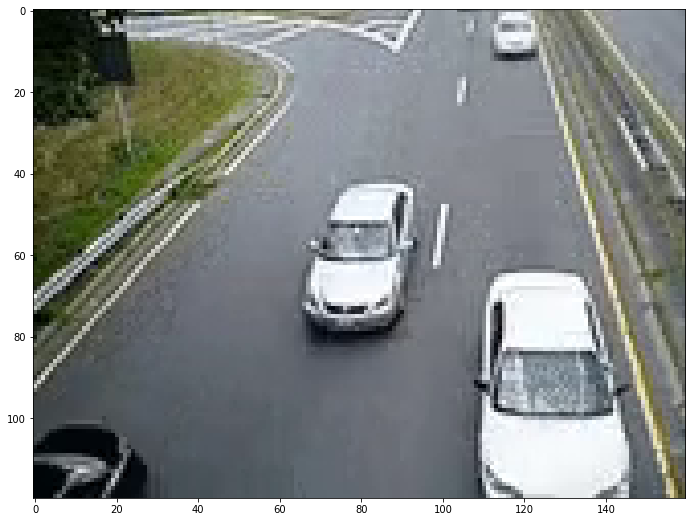

In [4]:


cap = cv2.VideoCapture("traffic.mp4")
fps = int(cap.get(cv2.CAP_PROP_FPS))
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

fc = 0

while (fc < frameCount): # while (fc < frameCount  and ret):
  ret, buf[fc] = cap.read()
  fc += 1

print('fps', fps, '\nframeCount', frameCount, '\nframeWidth', frameWidth, '\nframeHeight', frameHeight)
plt.imshow(cv2.cvtColor(buf[50], cv2.COLOR_BGR2RGB))
plt.show()

In [64]:
stacked = np.stack(buf, axis=2)
stacked.shape

(120, 160, 80, 3)

In [66]:
model = np.empty((frameHeight, frameWidth), dtype=GaussianMixture)

for h in range(frameHeight):
  for w in range(frameWidth):
    model[h][w] = GaussianMixture(n_components=1).fit(stacked[h][w])

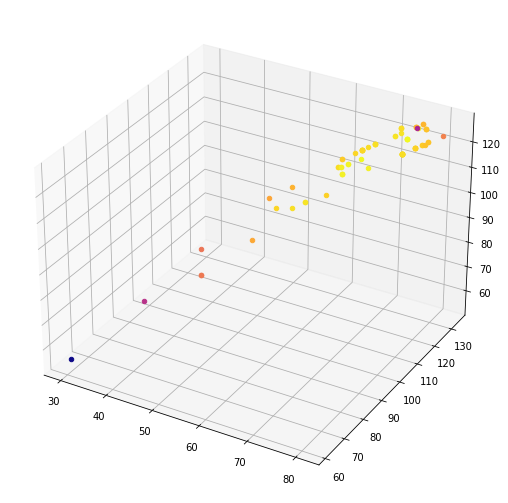

In [242]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scaler = MinMaxScaler()
# scaler = StandardScaler()
h = 40
w = 30

colors = plt.get_cmap('plasma')
scores = []
for point in stacked[h][w]:
  score = [(model[h][w].score_samples([point])[0])]
  scores.append(score)

scores = scaler.fit_transform(scores)
for score, point in zip(scores, stacked[h][w]):
  color = colors(score)
  xs, ys, zs = point
  ax.scatter(xs, ys, zs, color=color)

In [129]:
background = np.empty((frameHeight, frameWidth, 3), np.dtype('uint8'))

for h in range(frameHeight):
  for w in range(frameWidth):
    background[h][w] = [*map(int, model[h][w].means_[0])]



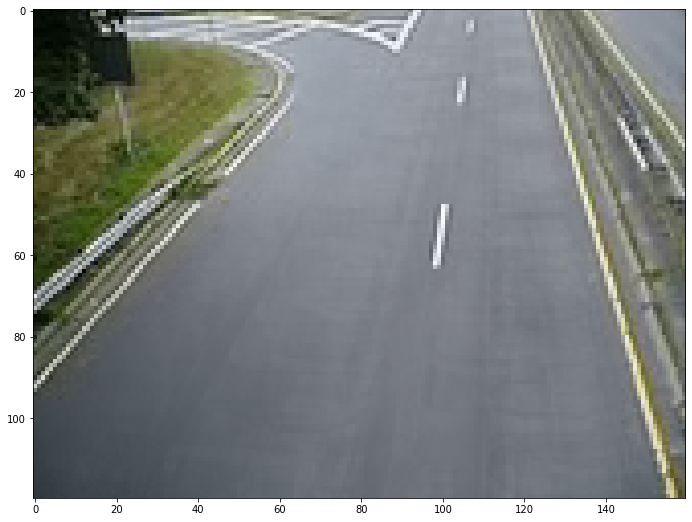

In [130]:
plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
plt.show()

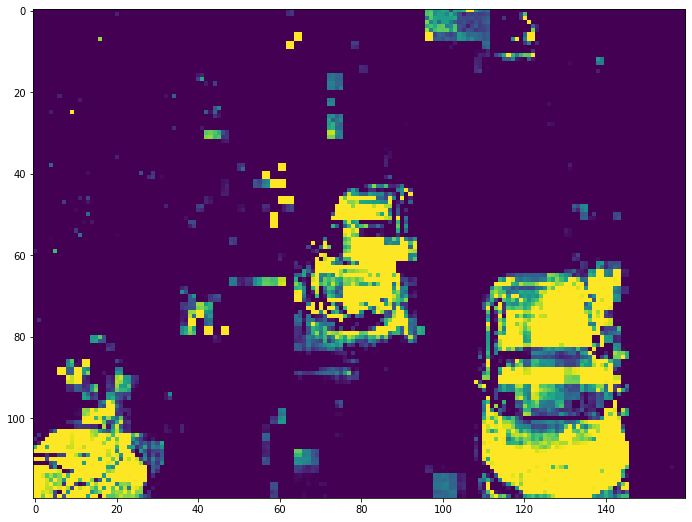

In [236]:
def squeeze(minimum, maximum, value):
  return min(maximum, max(minimum, value) - minimum)

movement = np.zeros((frameHeight, frameWidth, 1), np.dtype('uint8'))
frame = buf[50]

for h in range(frameHeight):
  for w in range(frameWidth):
    score = model[h][w].score_samples([frame[h][w]])[0]**2
    score = squeeze(100, 110, score)
    movement[h][w] = score

plt.imshow(movement)
plt.show()

In [126]:
results = []
for i in range(frameCount):
  movement = np.zeros((frameHeight, frameWidth, 3), np.dtype('uint8'))
  frame = buf[i]

  for h in range(frameHeight):
    for w in range(frameWidth):
      score = model[h][w].score_samples([frame[h][w]])[0]**2
      score = squeeze(100, 150, score)
      movement[h][w] = score
  if i % 10 == 0:
    print(f'frame {i+1}/{frameCount}')
  results.append(movement)

frame 1/80
frame 11/80
frame 21/80
frame 31/80
frame 41/80
frame 51/80
frame 61/80
frame 71/80


In [122]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('traffic_movement.mp4', fourcc, float(fps), (frameWidth, frameHeight))

for f in results:
  video.write(f)

video.release()  

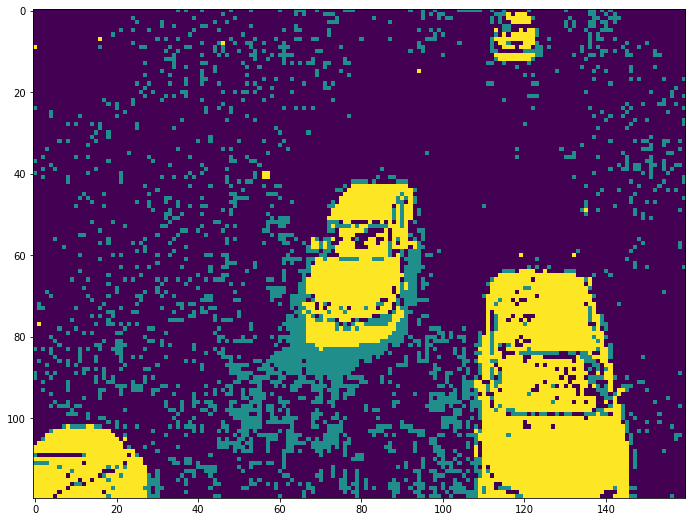

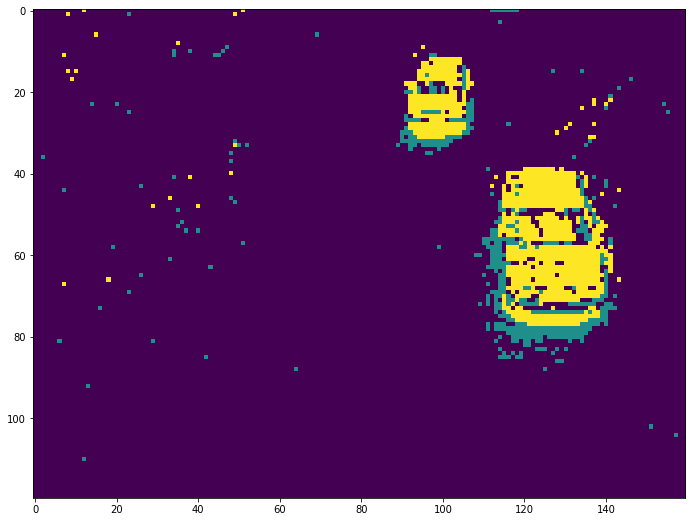

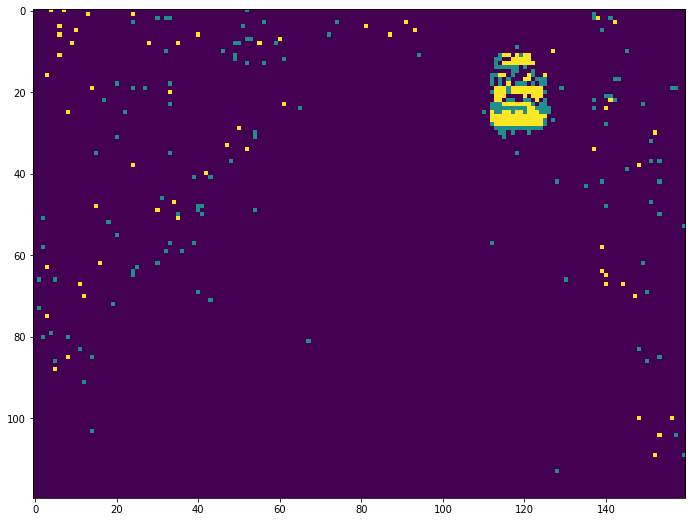

In [128]:
video2 = cv2.VideoWriter('traffic_movement_prod.mp4', fourcc, float(fps), (frameWidth, frameHeight))
backSub = cv2.createBackgroundSubtractorMOG2()
frames_to_plot = [50, 60, 70]

for i, frame in enumerate(buf):
  fgMask = backSub.apply(frame)
  video2.write(cv2.cvtColor(fgMask, cv2.COLOR_GRAY2BGR))
  if i in frames_to_plot:
    plt.imshow(fgMask)
    plt.show()

video2.release()